In [18]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from lib.data_generation import SignalConfig, generate_composite_signal, generate_batches

In [20]:
n_sessions = 10
sample_rate = 100

signals = []
for session_idx in range(n_sessions):
    duration_seconds = np.random.normal(45 * 60, 10 * 60)
    duration_seconds = np.clip(duration_seconds, 15 * 60, 90 * 60)
    dominant_signal_starting_frequency = np.random.normal(0.2, 0.08)
    dominant_signal_ending_frequency = np.random.normal(0.7, 0.08)
    dominant_signal_amplitude = np.random.normal(200, 50)
    dominant_signal_noise_level = np.random.normal(5, 1)
    dominant_signal_phase_offset = np.random.normal(0, 0.1)
    secondary_signal_starting_frequency = np.random.normal(1.1, 0.08)
    secondary_signal_ending_frequency = np.random.normal(2.5, 0.08)
    secondary_signal_amplitude = np.random.normal(10, 2)
    secondary_signal_noise_level = np.random.normal(5, 1)
    secondary_signal_phase_offset = np.random.normal(0, 0.1)
    
    signal_configs = [
        SignalConfig(frequency=[dominant_signal_starting_frequency, dominant_signal_ending_frequency], 
                     amplitude=dominant_signal_amplitude, 
                     noise_level=dominant_signal_noise_level, 
                     phase_offset=dominant_signal_phase_offset),
        SignalConfig(frequency=[secondary_signal_starting_frequency, secondary_signal_ending_frequency], amplitude=secondary_signal_amplitude, noise_level=secondary_signal_noise_level, phase_offset=secondary_signal_phase_offset),
    ]
    
    t, sensor_signal_1 = generate_composite_signal(duration_seconds=duration_seconds, 
                                                sample_rate=sample_rate, 
                                                signal_configs=signal_configs)
    signals.append(sensor_signal_1)
    
print(len(signals))

10


In [21]:
all_batches = []
for signal in signals:
    batches = generate_batches(signal, sample_rate)
    all_batches.extend(batches)

print(len(all_batches))

967


In [22]:
x = []
y = []

n_alterations = 10
for batch in all_batches:
    original_signal = batch
    
    for _ in range(n_alterations):
        # Alter the signal
        noise_level = np.random.normal(100, 50)
        noise_level = np.clip(noise_level, 0, 200)
        phase_offset = np.random.normal(0, 0.1)
        phase_offset = np.clip(phase_offset, -0.5, 0.5)
        altered_signal = batch + np.random.normal(0, noise_level, len(batch))
        altered_signal = np.roll(altered_signal, int(phase_offset * sample_rate))

        x.append(altered_signal)
        y.append(original_signal)

x = np.array(x)
y = np.array(y)

print(x.shape, y.shape)

(9670, 3000) (9670, 3000)


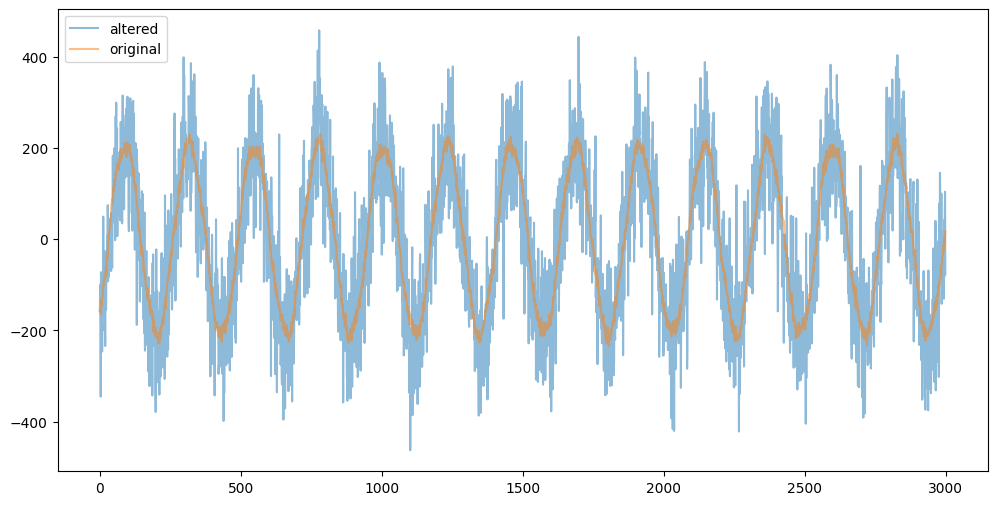

In [23]:
f = plt.figure(figsize=(12, 6))
i = np.random.randint(0, len(x))
plt.plot(x[i], label='altered', alpha=0.5)
plt.plot(y[i], label='original', alpha=0.5)
plt.legend()
plt.show()


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeStepDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()  # Convert to float32 for MPS compatibility
        self.Y = torch.from_numpy(Y).float()  # Convert to float32 for MPS compatibility

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_val_split = 0.8
indices = np.random.permutation(len(x))
split_idx = int(len(x) * train_val_split)
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

x_train = x[train_indices]
y_train = y[train_indices]
x_val = x[val_indices]
y_val = y[val_indices]

train_ds = TimeStepDataset(x_train, y_train)
val_ds = TimeStepDataset(x_val, y_val)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=False)
val_loader  = DataLoader(val_ds,  batch_size=256, shuffle=False)

In [25]:
from lib.reconstruction_model import SignalReconstructor

model = SignalReconstructor()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: mps


SignalReconstructor(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose1d(32, 16, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReL

In [26]:
from torch import nn

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [27]:
import copy

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    total_batches = 0

    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device).float()  # Convert to float32 for MPS compatibility
            logits = model(xb)
            loss = criterion(logits, yb)

            if train:
                optimizer.zero_grad()
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clip gradients
                optimizer.step()

            total_loss += loss.item()
            total_batches += 1

    return total_loss / total_batches

best_val_loss = float('inf')
best_model_state = None
epochs_no_improve = 0
patience = 10
n_epochs = 1000
training_record = {}

for epoch in range(n_epochs):
    train_loss = run_epoch(train_loader, train=True)
    val_loss   = run_epoch(val_loader, train=False)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:02d}  train_loss={train_loss:.6f}  val_loss={val_loss:.6f}  lr={current_lr:.6f}")
    training_record[epoch] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'lr': current_lr
    }
    
    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"  → New best model (val_loss={val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  → No improvement for {epochs_no_improve} epoch(s)")
    
    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

KeyboardInterrupt: 

In [ ]:
# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss={best_val_loss:.4f}")

In [ ]:
epochs_list = list(training_record.keys())
train_losses = [training_record[e]['train_loss'] for e in epochs_list]
val_losses = [training_record[e]['val_loss'] for e in epochs_list]

plt.figure(figsize=(8, 5))
plt.plot(epochs_list, train_losses, label='Training', linewidth=2, color='#2E86AB')
plt.plot(epochs_list, val_losses, label='Validation', linewidth=2, color='#A23B72')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('training_validation_loss.pdf', dpi=300, bbox_inches='tight')
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import datetime

model.eval()
time_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"reconstruction_model_{time_str}.pth"
torch.save({'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           model_path)

In [ ]:
import glob
import os

# Find the most recent model file
model_files = glob.glob("reconstruction_model_*.pth")
if model_files:
    latest_model = max(model_files, key=os.path.getctime)
    checkpoint = torch.load(latest_model)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded model from {latest_model}")
else:
    print("No saved model found")


Loaded model from reconstruction_model_20251125_103227.pth


In [ ]:
with torch.no_grad():
    x_t = torch.from_numpy(x.astype(np.float32)).to(device)
    preds = model(x_t).cpu().numpy()
    
results_df = pd.DataFrame({
    "true": list(y),
    "pred": list(preds)
}, index=np.arange(len(y)))

results_df["is_train"] = np.isin(results_df.index, x_train)
results_df["is_val"] = np.isin(results_df.index, x_val)

In [ ]:
error = np.zeros(len(preds))
for i in range(len(preds)): 
    f = preds[i] - y[i]
    error[i] = f.sum()
    
results_df['error'] = error
results_df['error_abs'] = np.abs(results_df['error'])

results_df.head()

,true,pred,is_train,is_val,error,error_abs
0,"[3.5400490835728435, 12.818050292576135, 12.87...","[17.67066, 29.932072, 41.065727, 41.511784, 41...",False,False,-4654.452411,4654.452411
1,"[3.5400490835728435, 12.818050292576135, 12.87...","[-92.4712, -123.66377, -140.34439, -136.44534,...",False,False,145.747322,145.747322
2,"[3.5400490835728435, 12.818050292576135, 12.87...","[48.002136, 67.96738, 82.66187, 81.47467, 79.4...",False,False,6023.619096,6023.619096
3,"[3.5400490835728435, 12.818050292576135, 12.87...","[9.772087, 13.074171, 18.377655, 20.27077, 21....",False,False,-6942.922791,6942.922791
4,"[3.5400490835728435, 12.818050292576135, 12.87...","[-75.11493, -64.597374, -55.06074, -58.575104,...",False,False,-4605.307978,4605.307978


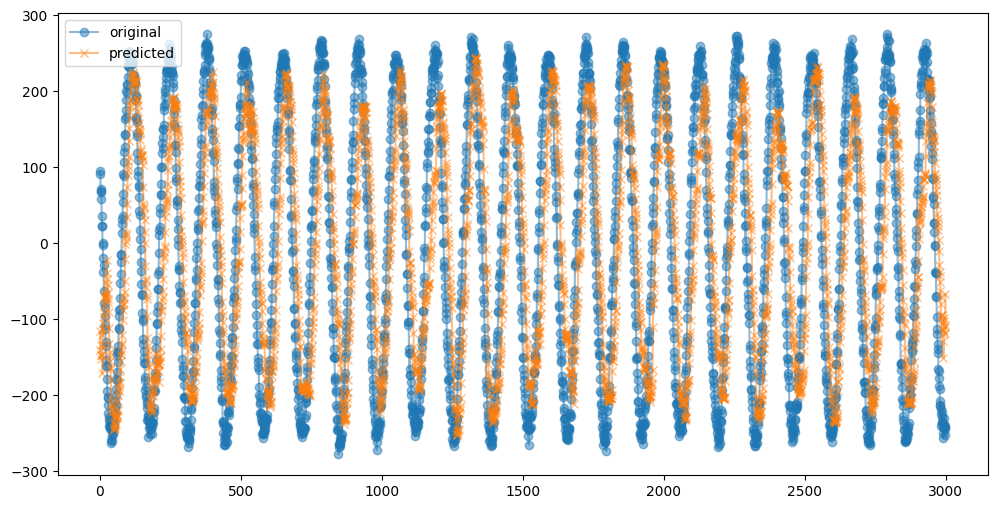

In [ ]:
f = plt.figure(figsize=(12, 6))

i = np.random.randint(0, len(results_df))
plt.plot(results_df.true.iloc[i], label='original', alpha=0.5, marker='o')
plt.plot(results_df.pred.iloc[i], label='predicted', alpha=0.5, marker='x')
plt.legend()
plt.show()


In [32]:
from scipy import signal
post_train_y = []

for original_signal in y:
    # Plot the original signal
    # plt.figure(figsize=(12, 6))
    # t = np.arange(len(original_signal)) / sample_rate
    # plt.plot(t, original_signal)
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    # plt.title('Original Signal')
    # plt.grid(True)
    # plt.show()
    
    # Compute the frequency spectrum using FFT
    signal_less_dc = original_signal - np.mean(original_signal)
    
    # Compute the frequency spectrum using FFT
    fft_result = np.fft.fft(signal_less_dc)
    fft_magnitude = np.abs(fft_result)
    frequencies = np.fft.fftfreq(len(signal_less_dc), 1/sample_rate)
    
    # Only keep positive frequencies
    positive_freq_idx = frequencies > 0
    frequencies = frequencies[positive_freq_idx]
    fft_magnitude = fft_magnitude[positive_freq_idx]
    
    # Plot the frequency spectrum
    # plt.figure(figsize=(12, 6))
    # plt.plot(frequencies, fft_magnitude)
    # plt.xlabel('Frequency')
    # plt.ylabel('Magnitude')
    # plt.title('FFT Magnitude Spectrum of Original Signal')
    # plt.grid(True)
    # plt.show()
    
    # Find the frequency with the highest magnitude
    max_magnitude_idx = np.argmax(fft_magnitude)
    max_magnitude_frequency = frequencies[max_magnitude_idx]
    # print(f"Highest magnitude frequency: {max_magnitude_frequency}")
    post_train_y.append(max_magnitude_frequency)
    # break
    
post_train_y = np.array(post_train_y)

<Axes: ylabel='Count'>

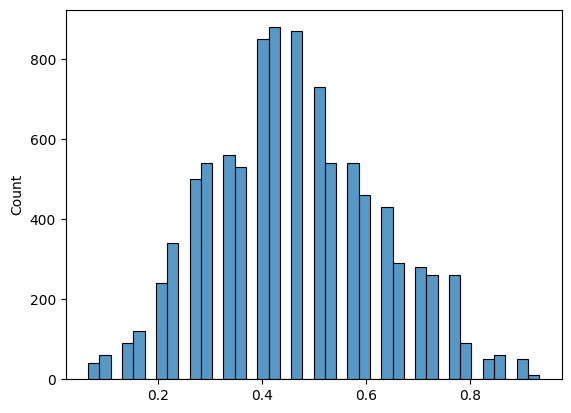

In [34]:
import seaborn as sns
sns.histplot(post_train_y)

In [39]:
class FrequencyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

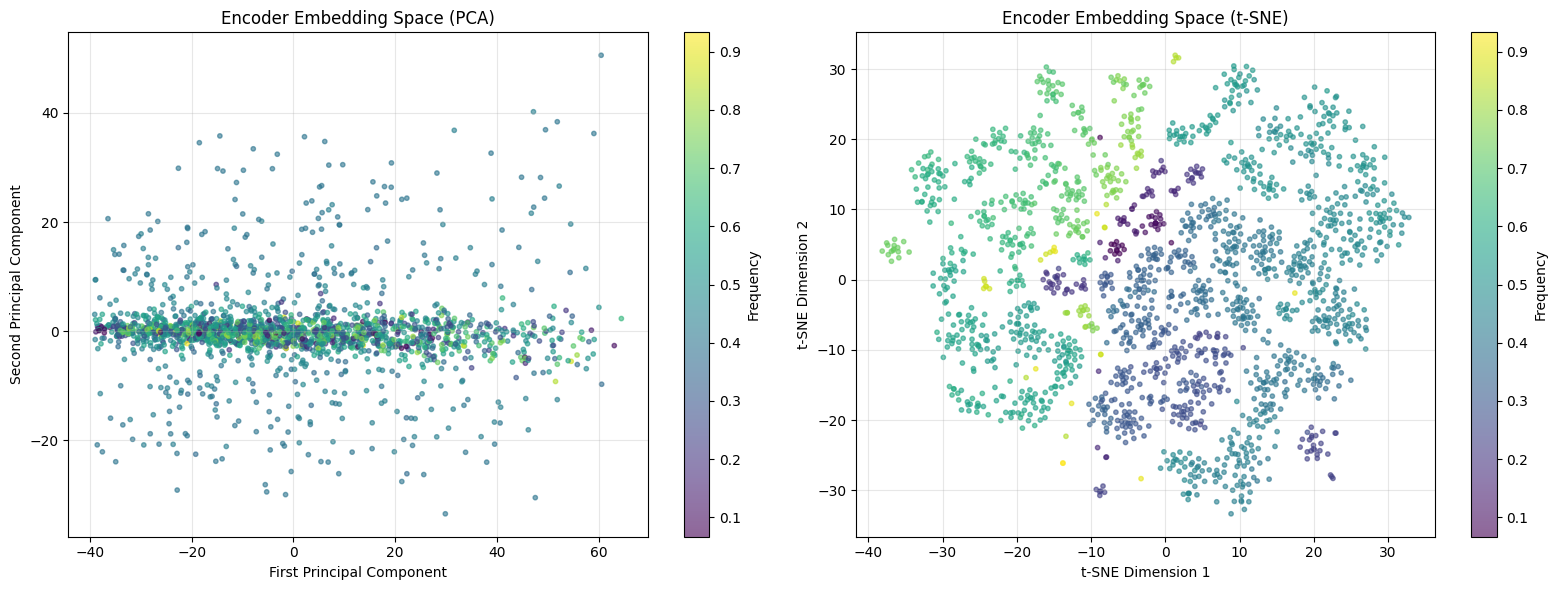

Embedding shape: (1934, 24000)
PCA explained variance ratio: [0.05749747 0.00667327]


In [48]:
# Visualize the encoder's embedding space
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get embeddings from the encoder
model.eval()
with torch.no_grad():
    # Use validation set for visualization
    # x_val has shape (n_samples, sequence_length), need to add channel dimension
    x_val_tensor = torch.from_numpy(x_val).float().unsqueeze(1).to(device)  # Add channel dimension
    embeddings = model.encoder(x_val_tensor)
    # Flatten the embeddings (batch_size, channels, length) -> (batch_size, features)
    embeddings = embeddings.view(embeddings.size(0), -1).cpu().numpy()

# Get corresponding frequencies for coloring
val_frequencies = post_train_y[val_indices]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings)

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA visualization
scatter1 = axes[0].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], 
                           c=val_frequencies, cmap='viridis', alpha=0.6, s=10)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('Encoder Embedding Space (PCA)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Frequency')

# t-SNE visualization
scatter2 = axes[1].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                           c=val_frequencies, cmap='viridis', alpha=0.6, s=10)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('Encoder Embedding Space (t-SNE)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Frequency')

plt.tight_layout()
plt.show()

print(f"Embedding shape: {embeddings.shape}")
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")


Starting downstream task training on mps...
Epoch 0: Train Loss 0.377589, Val Loss 0.109913, LR 0.001000
Epoch 10: Train Loss 0.022554, Val Loss 0.009464, LR 0.001000
Epoch 20: Train Loss 0.007445, Val Loss 0.005265, LR 0.001000
Epoch 30: Train Loss 0.004196, Val Loss 0.004150, LR 0.001000
Epoch 40: Train Loss 0.002862, Val Loss 0.003683, LR 0.001000
Epoch 50: Train Loss 0.002222, Val Loss 0.003909, LR 0.001000
Epoch 60: Train Loss 0.001878, Val Loss 0.003650, LR 0.000500
Epoch 70: Train Loss 0.001783, Val Loss 0.003312, LR 0.000125
Epoch 80: Train Loss 0.001747, Val Loss 0.003342, LR 0.000031
Epoch 90: Train Loss 0.001581, Val Loss 0.003400, LR 0.000016
Epoch 100: Train Loss 0.001696, Val Loss 0.003369, LR 0.000004
Epoch 110: Train Loss 0.001667, Val Loss 0.003231, LR 0.000001
Epoch 120: Train Loss 0.001628, Val Loss 0.003218, LR 0.000000
Epoch 130: Train Loss 0.001587, Val Loss 0.003347, LR 0.000000
Epoch 140: Train Loss 0.001686, Val Loss 0.003427, LR 0.000000
Epoch 150: Train Loss 

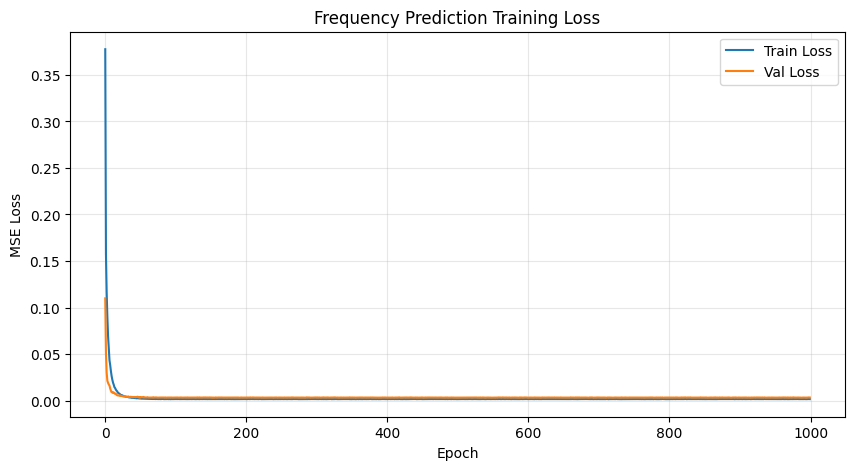

In [40]:
from lib.downstream_model import FrequencyPredictor

batch_size = 256
predictor = FrequencyPredictor(model.encoder).to(device)

post_train_y_train = post_train_y[train_indices]
post_train_y_val = post_train_y[val_indices]

train_ds = FrequencyDataset(x_train, post_train_y_train)
val_ds = FrequencyDataset(x_val, post_train_y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.head.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []

print(f"Starting downstream task training on {device}...")

for epoch in range(n_epochs):
    # Train
    predictor.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        preds = predictor(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validate
    predictor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = predictor(xb).squeeze()
            loss = criterion(preds, yb)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    if epoch % 10 == 0 or epoch == n_epochs - 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}: Train Loss {avg_train_loss:.6f}, Val Loss {avg_val_loss:.6f}, LR {current_lr:.6f}")
        
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(predictor.state_dict())
        
print(f"Best Val Loss: {best_val_loss:.6f}")

# Restore best
predictor.load_state_dict(best_model_state)

# Plot history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Frequency Prediction Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print(post_train_y.shape, x.shape)

(9670, 3000) (9670, 3000)


(9670,) (9670,)


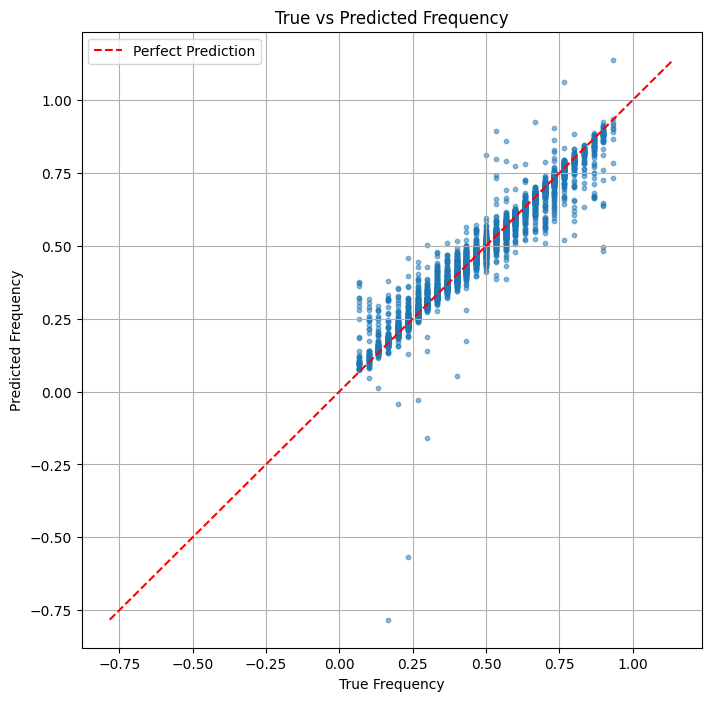

In [46]:
predictor.eval()
with torch.no_grad():
    x_tensor = torch.from_numpy(x).float().to(device)
    preds = predictor(x_tensor).squeeze().cpu().numpy()
    
print(post_train_y.shape, preds.shape)
plt.figure(figsize=(8, 8))
plt.scatter(post_train_y, preds, alpha=0.5, s=10)

# Plot perfect prediction line
min_val = min(post_train_y.min(), preds.min())
max_val = max(post_train_y.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('True Frequency')
plt.ylabel('Predicted Frequency')
plt.title('True vs Predicted Frequency')
plt.legend()
plt.grid(True)
plt.show()

Generate a bunch of these train a model with a contrastive loss using slightly different altered versions of the signal. Post train on top of those embeddings to estimate the frequency of the low and high amplitude signals.